# Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
SEQ_LEN = 60
BATCH_SIZE = 64

# Uso de "Device"

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carga de datos

In [3]:
data = pd.read_csv('coin_Bitcoin.csv')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
print(data.count())
data.head()

Open      2991
High      2991
Low       2991
Close     2991
Volume    2991
dtype: int64


,Open,High,Low,Close,Volume
0,134.444000,147.488007,134.000000,144.539993,0.0
1,144.000000,146.929993,134.050003,139.000000,0.0
2,139.000000,139.889999,107.720001,116.989998,0.0
3,116.379997,125.599998,92.281898,105.209999,0.0
4,106.250000,108.127998,79.099998,97.750000,0.0


# Preprocesamiento de datos

In [4]:
# Normalizar los datos
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Crear secuencias de entrada y salida
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][3]  # Usamos el precio de cierre como objetivo
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 30  # Longitud de las secuencias
X, y = create_sequences(data_scaled, SEQ_LEN)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Definición de Modelo

In [5]:
# Definir la clase BitcoinLSTM con Dropout y Batch Normalization
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(BitcoinLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.batch_norm(out[:, -1, :])
        out = self.dropout(out)
        out = self.fc(out)
        return out

input_size = X_train.shape[2]
hidden_size = 50
num_layers = 2
output_size = 1

model = BitcoinLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Entrenamiento del Modelo

/home/silva/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/silva/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Train Loss: 0.0104, Test Loss: 0.1641
Epoch [2/15], Train Loss: 0.0039, Test Loss: 0.1541
Epoch [3/15], Train Loss: 0.0037, Test Loss: 0.1823
Epoch [4/15], Train Loss: 0.0037, Test Loss: 0.1722
Epoch [5/15], Train Loss: 0.0037, Test Loss: 0.1867
Epoch [6/15], Train Loss: 0.0037, Test Loss: 0.1489
Epoch [7/15], Train Loss: 0.0036, Test Loss: 0.1745
Epoch [8/15], Train Loss: 0.0036, Test Loss: 0.1650
Epoch [9/15], Train Loss: 0.0036, Test Loss: 0.1575
Epoch [10/15], Train Loss: 0.0036, Test Loss: 0.1725
Epoch [11/15], Train Loss: 0.0036, Test Loss: 0.1749
Epoch [12/15], Train Loss: 0.0036, Test Loss: 0.1722
Epoch [13/15], Train Loss: 0.0036, Test Loss: 0.1926
Epoch [14/15], Train Loss: 0.0036, Test Loss: 0.1620
Epoch [15/15], Train Loss: 0.0036, Test Loss: 0.1733


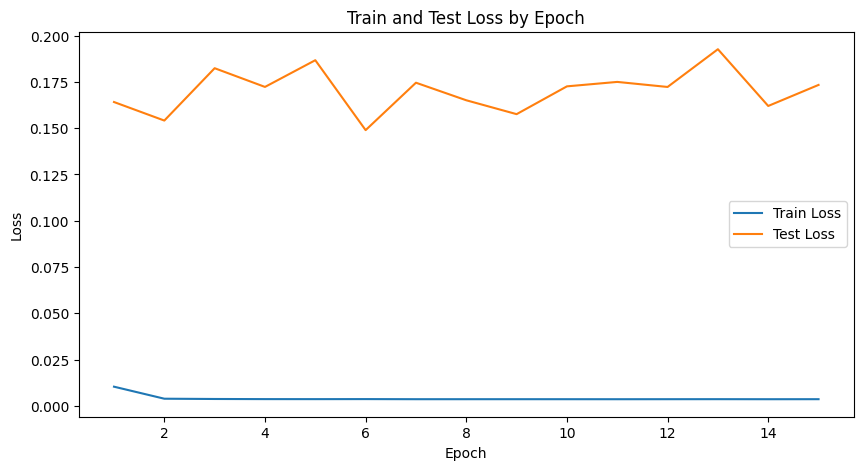

In [6]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Entrenar el modelo
num_epochs = 15
train_losses = []
test_losses = []

model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_dataloader)
    train_losses.append(epoch_loss)
    
    # Evaluar en el conjunto de prueba
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)
    
    model.train()
    scheduler.step(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}')

# Graficar las pérdidas de entrenamiento y prueba por época
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss by Epoch')
plt.legend()
plt.show()

# Evaluar el modelo

Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0000
R² Score: 1.0000


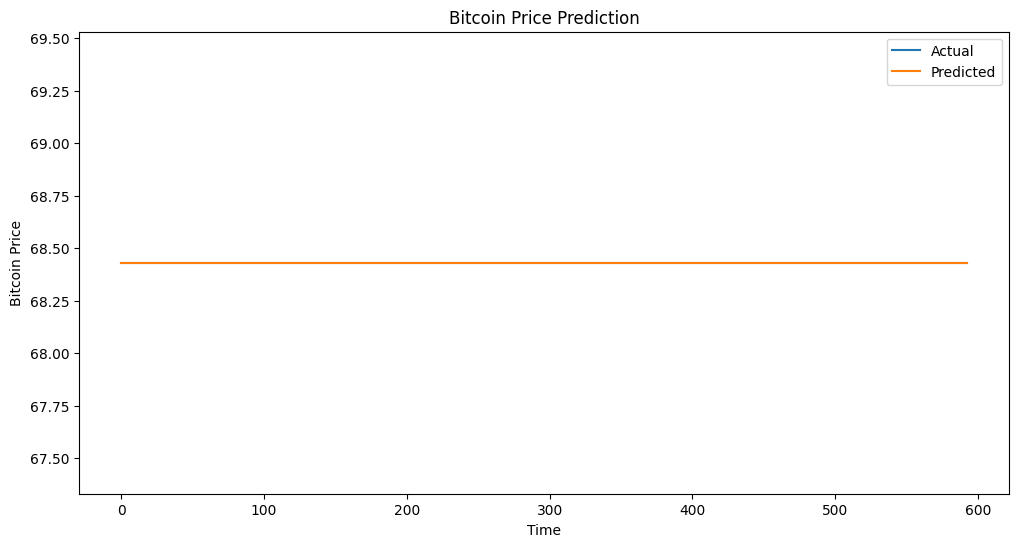

In [7]:
# Evaluar el modelo y obtener las predicciones
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Convertir las listas a arrays
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Agregar una dimensión adicional a actuals
actuals = actuals.reshape(-1, 1)

# Desnormalizar las predicciones y los valores reales
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], 4)), predictions), axis=1))[:, 3]
actuals = scaler.inverse_transform(np.concatenate((np.zeros((actuals.shape[0], 4)), actuals), axis=1))[:, 3]

# Calcular las métricas de regresión
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

# Graficar las predicciones y los valores reales
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.legend()

# Establecer los límites del eje y basados en los valores mínimos y máximos desnormalizados con un margen
y_min = min(min(actuals), min(predictions)) - 1
y_max = max(max(actuals), max(predictions)) + 1
margin = (y_max - y_min) * 0.05  # 5% de margen
plt.ylim(y_min - margin, y_max + margin)

plt.show()